In [12]:
from __future__ import print_function 
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils import data
from ResNet import *
from run_model import *


import time
import os
import copy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets, models, transforms
from collections import OrderedDict
from PIL import Image
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.4.0a0+649135b
Torchvision Version:  0.5.0a0


In [13]:
from dataloader import RetinopathyLoader

In [14]:
# Batch size for training (change depending on how much memory you have)
batch_size = 32

train_set = RetinopathyLoader(root='./data/',mode='train')
train_loader = data.DataLoader(dataset=train_set,batch_size=batch_size)
test_set = RetinopathyLoader(root='./data/',mode='test')
test_loader = data.DataLoader(dataset=test_set,batch_size=batch_size)

dataloaders_dict = {'train':train_loader,
                    'val' : test_loader}

> Found 28099 images...
> Found 7025 images...


In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [16]:
# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "resnet18"

# Number of classes in the dataset
num_classes = 5



# Number of epochs to train for 
num_epochs = 10

# Setup the loss fxn
# Because the data imbalance, we use weight Tensor w to adjust
w = [200,40,20,7,6]
w = [1- (a/sum(w)) for a in w]
w = torch.Tensor(w).to(device)
print(w)
criterion = nn.CrossEntropyLoss(weight=w)

tensor([0.2674, 0.8535, 0.9267, 0.9744, 0.9780], device='cuda:0')


In [17]:
def get_pretrained_model(model_name, num_classes,use_pretrained=True):
    model_dict = {
        'resnet18':  models.resnet18,
        'resnet34':  models.resnet34,
        'resnet50':  models.resnet50,
        'resnet101': models.resnet101,
        'resnet152': models.resnet152
    }
    
    model_ft = model_dict[model_name](pretrained=use_pretrained)          
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, num_classes)
    input_size = 224
    
    return model_ft, input_size

## Run ResNet pretrained model which is from `torchvision`

In [31]:
# Initialize the pretrained model for this run
model_ft, input_size = get_pretrained_model(model_name, num_classes=5)
# Send the model to GPU
model_ft = model_ft.to(device)


In [32]:
# Setup optimizer
optimizer_ft = optim.SGD(model_ft.parameters(), lr=1e-3, weight_decay=1e-2, momentum=0.9)
lr_sch = optim.lr_scheduler.ReduceLROnPlateau(optimizer_ft)

# Train and evaluate pretrained model
pretrained_loss_list, pretrained_acc_train_list, pretrained_acc_test_list = \
run(model_ft, dataloaders_dict, criterion, optimizer=optimizer_ft,\
        scheduler=lr_sch,num_epochs=num_epochs)

Epoch 1/10
----------
train Loss: 1.1356 Acc: 0.6607
train pred_list.value_counts() = 
0    20006
2     6984
1      454
4      432
3      223
dtype: int64
val Loss: 1.0347 Acc: 0.6864
val pred_list.value_counts() = 
0    4899
2    1588
1     366
4      93
3      79
dtype: int64
Epoch 2/10
----------
train Loss: 0.9976 Acc: 0.7102
train pred_list.value_counts() = 
0    20322
2     6575
4      471
1      404
3      327
dtype: int64
val Loss: 1.0028 Acc: 0.7463
val pred_list.value_counts() = 
0    5546
2    1213
1     127
4      73
3      66
dtype: int64
Epoch 3/10
----------
train Loss: 0.9291 Acc: 0.7301
train pred_list.value_counts() = 
0    20342
2     6472
4      480
1      461
3      344
dtype: int64
val Loss: 0.9842 Acc: 0.7160
val pred_list.value_counts() = 
0    5025
2    1491
1     348
3      86
4      75
dtype: int64
Epoch 4/10
----------
train Loss: 0.8690 Acc: 0.7475
train pred_list.value_counts() = 
0    20298
2     6342
1      585
4      492
3      382
dtype: int64
val Loss

In [33]:
torch.save(model_ft,'./models/vision_pretrained_resnet18')
torch.save(pretrained_loss_list,'./result_list/pretrained_loss_list')
torch.save(pretrained_acc_train_list, './result_list/pretrained_acc_train_list')
torch.save(pretrained_acc_test_list, './result_list/pretrained_acc_test_list')

## Run ResNet model (no pretrained) which is from `torchvision`

In [ ]:
# Initialize the non-pretrained version of the model used for this run
#scratch_model,_ = get_pretrained_model(model_name, num_classes=5, use_pretrained=False)
#scratch_model = scratch_model.to(device)
#scratch_loss_list, scratch_acc_train_list, scratch_acc_test_list = \
#    run(scratch_model, dataloaders_dict, criterion, num_epochs=num_epochs)

In [ ]:
#torch.save(scratch_model,'./models/vision_not_pretrained_resnet18')

## Run ResNet implemented by myself

In [ ]:
MyResNet18 = ResNet18(num_classes=5)
MyResNet18 = MyResNet18.to(device)

In [7]:
opt_MyResNet18 = optim.SGD(MyResNet18.parameters(), lr=1e-3,weight_decay=5e-4, momentum=0.9)
lr_sch = optim.lr_scheduler.ReduceLROnPlateau(opt_MyResNet18)

In [ ]:
my_loss_list, my_acc_train_list, my_acc_test_list = \
    run(MyResNet18, dataloaders_dict, criterion, optimizer=opt_MyResNet18,\
        scheduler=lr_sch,num_epochs=num_epochs)

In [ ]:
torch.save(MyResNet18,'./models/my_resnet18')
torch.save(my_loss_list,'./result_list/my_loss_list_18')
torch.save(my_acc_train_list, './result_list/my_acc_train_list_18')
torch.save(my_acc_test_list, './result_list/my_acc_test_list_18')

### Train with more epochs

In [15]:
MyResNet18 = torch.load('./models/vision_pretrained_resnet18')

In [ ]:
opt_MyResNet18 = optim.SGD(MyResNet18.parameters(), lr=1e-2,weight_decay=5e-3, momentum=0.9)
lr_sch = optim.lr_scheduler.ReduceLROnPlateau(opt_MyResNet18)
run(MyResNet18, dataloaders_dict, criterion, optimizer=opt_MyResNet18,\
        scheduler=lr_sch,num_epochs=5)

## Comparison

In [18]:
model_ft = torch.load('./models/vision_pretrained_resnet18')
pretrained_acc_test_list = torch.load('./result_list/pretrained_acc_test_list')

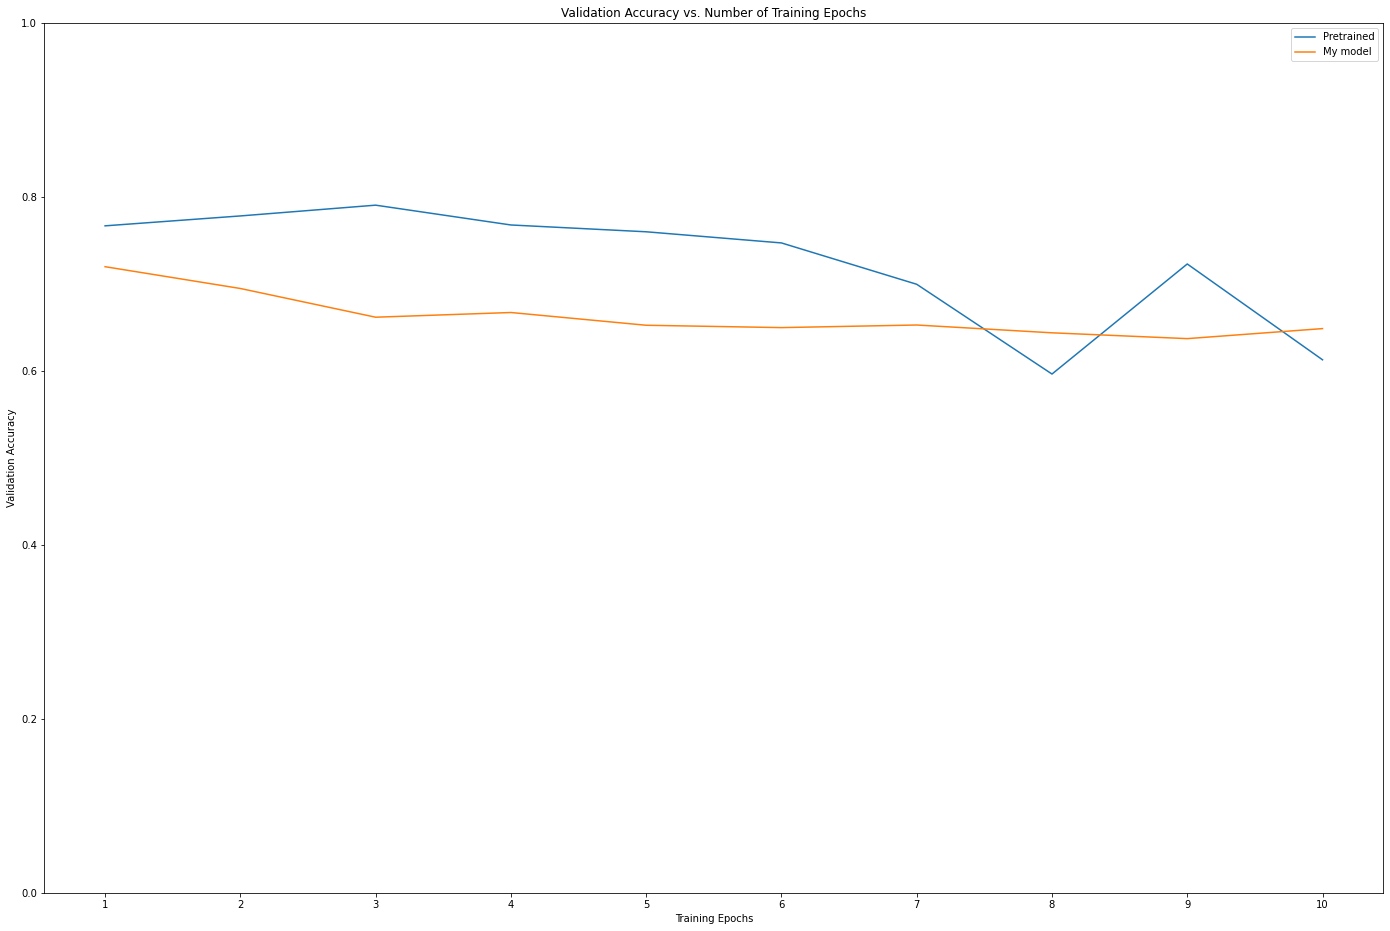

In [22]:
ohist  = [h.cpu().numpy() for h in pretrained_acc_test_list]
#shist  = [h.cpu().numpy() for h in scratch_acc_test_list]
myhist = [h.cpu().numpy() for h in my_acc_test_list]

plt.figure(figsize=(24,16))
plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),ohist,label="Pretrained")
#plt.plot(range(1,num_epochs+1),shist,label="Scratch")
plt.plot(range(1,num_epochs+1),myhist,label="My model")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

## ResNet 50

In [ ]:
# Initialize the pretrained model for this run
model_ft_50, input_size = get_pretrained_model('resnet50', num_classes=5)
print(model_ft_50)
# Send the model to GPU
model_ft_50 = model_ft_50.to(device)

In [ ]:
# Setup optimizer
#optimizer_ft = optim.SGD(model_ft.parameters(), lr=1e-3, weight_decay=5e-4, momentum=0.9)

# Setup optimizer
optimizer_ft_50 = optim.SGD(model_ft_50.parameters(), lr=1e-3, weight_decay=5e-4, momentum=0.9)
lr_sch = optim.lr_scheduler.ReduceLROnPlateau(optimizer_ft_50)


# Train and evaluate pretrained model
pretrained_loss_list_50, pretrained_acc_train_list_50, pretrained_acc_test_list_50 = \
    run(model_ft_50, dataloaders_dict, criterion, optimizer=optimizer_ft_50,\
        scheduler=lr_sch,num_epochs=5)

In [ ]:
torch.save(model_ft_50,'./models/vision_pretrained_resnet50')
torch.save(pretrained_loss_list_50,'./result_list/pretrained_loss_list_50')
torch.save(pretrained_acc_train_list_50, './result_list/pretrained_acc_train_list_50')
torch.save(pretrained_acc_test_list_50, './result_list/pretrained_acc_test_list_50')

In [ ]:
MyResNet50 = ResNet50(num_classes=5)
MyResNet50 = MyResNet50.to(device)
my_loss_list_50, my_acc_train_list_50, my_acc_test_list_50 = \
    run(MyResNet50, dataloaders_dict, criterion, num_epochs=5)

In [ ]:
torch.save(MyResNet50,'./models/my_resnet50')
torch.save(my_loss_list_50,'./result_list/my_loss_list_50')
torch.save(my_acc_train_list_50, './result_list/my_acc_train_list_50')
torch.save(my_acc_test_list_50, './result_list/my_acc_test_list_50')

In [ ]:
MyResNet101 = ResNet101(num_classes=5)
MyResNet101 = MyResNet101.to(device)
my_loss_list_101, my_acc_train_list_101, my_acc_test_list_101 = \
    run(MyResNet101, dataloaders_dict, criterion, num_epochs=5)

In [ ]:
torch.save(MyResNet101,'./models/my_resnet101')
torch.save(my_loss_list_101,'./result_list/my_loss_list_101')
torch.save(my_acc_train_list_101, './result_list/my_acc_train_list_101')
torch.save(my_acc_test_list_101, './result_list/my_acc_test_list_101')

# Run ResNet152

### With pretrained resnet 152

In [ ]:
pretrained_152 ,_ = get_pretrained_model(model_name='resnet152',num_classes=5)
pretrained_152 = pretrained_152.to(device)

In [ ]:
pretrained_152 = torch.load('./models/vision_pretrained_152')
pretrained_152 = pretrained_152.to(device)

In [ ]:
opt_pretrained_152 = optim.SGD(pretrained_152.parameters(), lr=1e-3,weight_decay=5e-4, momentum=0.9)
lr_sch = optim.lr_scheduler.ReduceLROnPlateau(opt_pretrained_152)

In [ ]:
pretrained_loss_list_152, pretrained_acc_train_list_152, pretrained_acc_test_list_152 = \
    run(pretrained_152, dataloaders_dict, criterion,optimizer=opt_pretrained_152\
        , scheduler=lr_sch, num_epochs=5)

In [ ]:
torch.save(pretrained_152,'./models/vision_pretrained_152')
torch.save(pretrained_loss_list_152,'./result_list/pretrained_loss_list_152')
torch.save(pretrained_acc_train_list_152, './result_list/pretrained_acc_train_list_152')
torch.save(pretrained_acc_test_list_152, './result_list/pretrained_acc_test_list_152')

In [ ]:
MyResNet152 = ResNet152(num_classes=5)
opt_MyResNet152 = optim.SGD(MyResNet152.parameters(), lr=1e-2,weight_decay=5e-3, momentum=0.9)
lr_sch = optim.lr_scheduler.ReduceLROnPlateau(opt_MyResNet152)
MyResNet152 = MyResNet152.to(device)
#print(MyResNet152)

In [ ]:
my_loss_list_152, my_acc_train_list_152, my_acc_test_list_152 = \
    run(MyResNet152, dataloaders_dict, criterion, optimizer=opt_MyResNet152,scheduler=lr_sch,\
        num_epochs=5)

In [ ]:
torch.save(MyResNet152,'./models/my_resnet152')
torch.save(my_loss_list_152,'./result_list/my_loss_list_152')
torch.save(my_acc_train_list_152, './result_list/my_acc_train_list_152')
torch.save(my_acc_test_list_152, './result_list/my_acc_test_list_152')

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)